In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

In [2]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [3]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [4]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

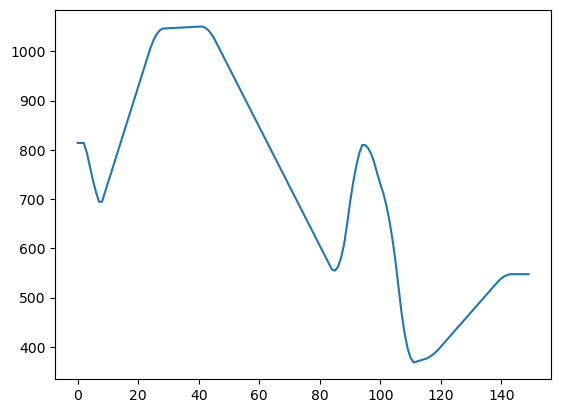

In [5]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])

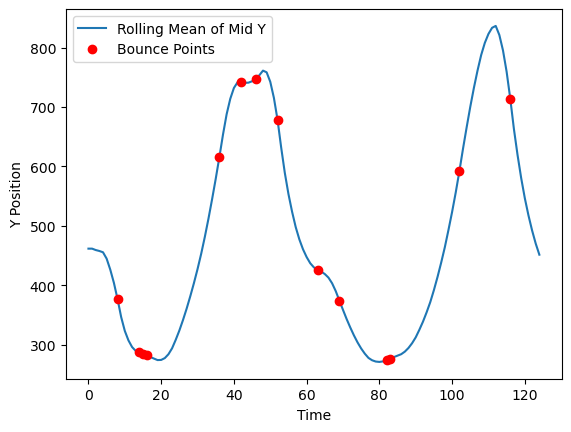

Potential bounce detected at index: 8, y_position: 376.9474273681641
Potential bounce detected at index: 14, y_position: 287.08899078369143
Potential bounce detected at index: 15, y_position: 284.5163543701172
Potential bounce detected at index: 16, y_position: 281.94371795654297
Potential bounce detected at index: 36, y_position: 615.5929977416993
Potential bounce detected at index: 42, y_position: 742.550537109375
Potential bounce detected at index: 46, y_position: 747.470263671875
Potential bounce detected at index: 52, y_position: 678.5427764892578
Potential bounce detected at index: 63, y_position: 425.7960662841797
Potential bounce detected at index: 69, y_position: 374.3828512573242
Potential bounce detected at index: 82, y_position: 274.42565409342444
Potential bounce detected at index: 83, y_position: 276.8431176079645
Potential bounce detected at index: 102, y_position: 591.7388671875
Potential bounce detected at index: 116, y_position: 714.0390197753907


In [32]:
# Calculate the first and second derivatives
df_ball_positions['mid_y_first_derivative'] = np.gradient(df_ball_positions['mid_y_rolling_mean'])
df_ball_positions['mid_y_second_derivative'] = np.gradient(df_ball_positions['mid_y_first_derivative'])

# Identify points where the second derivative changes sign
bounce_indices = np.where(np.diff(np.sign(df_ball_positions['mid_y_second_derivative'])))[0]

# Visualize the data with bounce points
plt.plot(df_ball_positions['mid_y_rolling_mean'], label='Rolling Mean of Mid Y')
plt.plot(bounce_indices, df_ball_positions['mid_y_rolling_mean'].iloc[bounce_indices], 'ro', label='Bounce Points')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# Print bounce points details
for index in bounce_indices:
    print(f"Potential bounce detected at index: {index}, y_position: {df_ball_positions['mid_y_rolling_mean'].iloc[index]}")

In [27]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

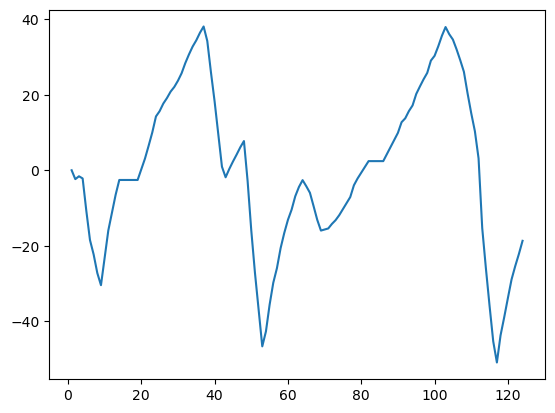

In [28]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])

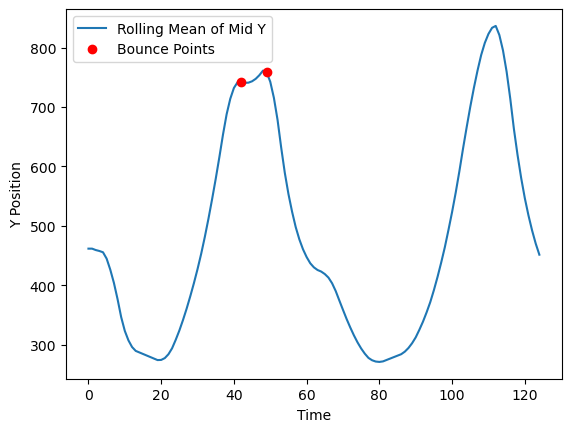

Bounce detected at index: 42, y_position: 742.550537109375
Bounce detected at index: 49, y_position: 758.4382446289062


In [29]:
# Identify peaks
peaks, _ = find_peaks(df_ball_positions['mid_y_rolling_mean'], distance=5)  # Adjust distance as needed

# Function to find the bounce in each segment based on delta_y
def find_bounce_segment(start, end, delta_y):
    segment = delta_y[start:end]
    bounce_index = np.argmax(np.abs(np.diff(segment))) + start
    return bounce_index

# Find bounce points between peaks
bounce_indices = []
for i in range(len(peaks) - 1):
    start = peaks[i]
    end = peaks[i + 1]
    bounce_index = find_bounce_segment(start, end, df_ball_positions['delta_y'])
    bounce_indices.append(bounce_index)

# Visualize the data with bounce points
plt.plot(df_ball_positions['mid_y_rolling_mean'], label='Rolling Mean of Mid Y')
plt.plot(bounce_indices, df_ball_positions['mid_y_rolling_mean'].iloc[bounce_indices], 'ro', label='Bounce Points')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# Print bounce points details
for index in bounce_indices:
    print(f"Bounce detected at index: {index}, y_position: {df_ball_positions['mid_y_rolling_mean'].iloc[index]}")

In [17]:
df_ball_positions['ball_hit']=0

In [18]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

/tmp/ipykernel_1273/135222774.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/tmp/ipykernel_1273/135222774.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/tmp/ipykernel_1273/135222774.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/tmp/ipykernel_1273/135222774.py:18: SettingWithCopyWarning: 
A 

In [20]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.865967,717.330017,796.806519,738.393188,727.861603,735.918115,6.523407,1
58,925.881409,240.971042,939.039478,253.989072,247.480057,243.406097,-1.957851,1
95,624.777161,748.891968,642.157257,766.698242,757.795105,775.403400,0.871759,1
131,716.963562,229.095024,729.239868,242.786232,235.940628,235.241684,-0.557164,1
182,1294.891235,739.127197,1314.160156,760.564819,749.846008,738.733578,5.602832,1
